In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
#Import data def
def gen_df(name):
    file = name+".csv"
    df = pd.read_csv(file)
    df.Date = pd.to_datetime(df.Date)
    df.sort_values(by="Date", inplace=True)
    df.set_index("Date",inplace=True)
    #df = df.drop(["VN30_Open", "Set100_Open"], axis =1) #Edit the master file to delete this line!
    return df

In [4]:
#For running new algo
name = input()
df = gen_df(name)

set100:vnm_edit


In [20]:
#Gen df_Stat df2

def genr_stat(dataframe):
    #Cal VN30/Set100
    dataframe[f'{df.columns[0]}/{dataframe.columns[1]}'] = dataframe[f'{dataframe.columns[0]}'].values.ravel()/dataframe[f'{df.columns[1]}'].values.ravel() #Fix slicing

    #EMA, MACD, Signal
    dataframe['EMA26'] = dataframe[f'{df.columns[0]}/{df.columns[1]}'].ewm(span = 26, adjust=False).mean() #spanday = 26
    dataframe['EMA12'] = dataframe[f'{df.columns[0]}/{df.columns[1]}'].ewm(span = 12, adjust=False).mean() #spanday = 12
    dataframe['MACD'] = dataframe.EMA12 - dataframe.EMA26 #Short-Long

    #Signal Genr and MACD-Signal
    signal_day = 9
    k = 2/(signal_day+1) #Weight of alpha

    #Gern Signal=9
    dataframe['Signal']=np.zeros(len(dataframe.index))
    dataframe['Signal'].iloc[0] = dataframe.MACD.iloc[0] #Zero is Nan

    for t in range(1,len(dataframe.MACD)):
        dataframe['Signal'].iloc[t] = (dataframe.MACD.iloc[t]*k)+(dataframe.Signal[t-1]*(1-k))

    #Shift Signal
    dataframe['Shift_Signal'] = dataframe['Signal'].shift(periods=1)
    dataframe['Shift_Signal'].iloc[0] = dataframe.Signal.iloc[0]
    return dataframe

In [37]:
#DCA not including Unrealized Value #Type1
def dollar_cost_average(dataframe, dataframe_stat, m_principal, freq=30): #Monthly principal and period,freq =30 days
    
    #Buying Condition
    '''Type1 = Buy VNI30 if Signal>MACD ==> df2['Shift_Signal'].iloc[num] >= df2['MACD'].iloc[num]
       Type2 = Buy Set100 if Signal>MACD ==> df2['Shift_Signal'].iloc[num] <= df2['MACD'].iloc[num]'''
    #Money_daily and monthly investment Date
    daily = m_principal/freq
    print(daily)
    
    #Keep num_VN, num_Set
    num_1, num_2 = [],[]
    
    #Total Balance
    '''Port_val = (accum_VN* current_VNprice)+(accum_Set* current_Setprice)+accum_cash'''
    accum_cash = []
    accum_1stock, accum_2stock = [],[]
    
    
    #Set Dataframe 1= VN, 2= Set
    dataframe['Num_1'] = np.zeros(len(dataframe.index))
    dataframe['Num_2'] = np.zeros(len(dataframe.index))
    dataframe['Accum_1'] = np.zeros(len(dataframe.index))
    dataframe['Accum_2'] = np.zeros(len(dataframe.index))
    dataframe['Port_Val'] = np.zeros(len(dataframe.index))
    dataframe['Cash_Balance'] = np.zeros(len(dataframe.index))
    dataframe['Total_Port'] = np.zeros(len(dataframe.index))
    
    for num in range(0,len(dataframe.index)):
        #Set condition for closing market
        #Both Markets are Opened
        if pd.isna(dataframe_stat[f'{dataframe.columns[0]}'].iloc[num]) != pd.isna(np.nan) and pd.isna(dataframe_stat[f'{dataframe.columns[1]}'].iloc[num]) != pd.isna(np.nan):
            
            #Decision Rules
            #Buy Vn30
            if dataframe_stat['Shift_Signal'].iloc[num] - dataframe_stat['MACD'].iloc[num] >=0:
                dataframe.iloc[num, dataframe.columns.get_loc('Num_1')] = np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])
                num_1.append(np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num]))
                current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])*dataframe[f'{dataframe.columns[0]}'].iloc[num] #Set Current Cash
                accum_cash.append(current_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Accum_1')] = sum(num_1) #Acc_VN
                #Only Holding_Stock Values
                dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num]*sum(num_1) + df[f'{dataframe.columns[1]}'].iloc[num]*sum(num_2)
                dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
                
            #Buy Set100    
            elif dataframe_stat['Shift_Signal'].iloc[num] - dataframe_stat['MACD'].iloc[num] <=0:
                dataframe.iloc[num, dataframe.columns.get_loc('Num_2')] = np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num])
                num_2.append(np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num]))
                current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num])*dataframe[f'{dataframe.columns[1]}'].iloc[num] #Set Current Cash
                accum_cash.append(current_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Accum_2')] = sum(num_2) #Acc_VN
                dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num]*sum(num_1) +df[f'{dataframe.columns[1]}'].iloc[num]*sum(num_2)
                dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
            
            else:
                pass
            
        #Condition when Stock1 mrk close
        elif pd.isna(dataframe_stat[f'{dataframe.columns[0]}'].iloc[num]) == pd.isna(np.nan):
            dataframe.iloc[num, dataframe.columns.get_loc('Num_2')] = np.floor(daily/df[f'{dataframe.columns[1]}'].iloc[num])
            num_2.append(np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num]))
            current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num])*dataframe[f'{dataframe.columns[1]}'].iloc[num] #Set Current Cash
            accum_cash.append(current_cash)
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_2')] = sum(num_2) #Acc_VN
            dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num-1]*sum(num_1) + df[f'{dataframe.columns[1]}'].iloc[num]*sum(num_2)
            dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash[:num-1])
            dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
              
        #Condition when Stock2 mrk close
        elif pd.isna(dataframe_stat[f'{dataframe.columns[1]}'].iloc[num]) == pd.isna(np.nan):
            dataframe.iloc[num, dataframe.columns.get_loc('Num_1')] = np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])
            num_1.append(np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num]))
            current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])*dataframe[f'{dataframe.columns[0]}'].iloc[num] #Set Current Cash
            accum_cash.append(current_cash)
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_1')] = sum(num_1) #Acc_VN
            dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num]*sum(num_1) +dataframe[f'{dataframe.columns[1]}'].iloc[num-1]*sum(num_2)
            dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash[:num-1])
            dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
        
        #Condition when two market close
        elif pd.isna(dataframe_stat[f'{dataframe.columns[0]}'].iloc[num] == pd.isna(np.nan)) and pd.isna(dataframe_stat[f'{dataframe.columns[1]}'].iloc[num] == pd.isna(np.nan)):
            accum_cash.append(0)
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_1')] = num_1[num-1] #Acc_1
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_2')] = num_2[num-1] #Acc_1
            dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe.Port_Val.iloc[num-1]
            dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash)
            dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
    
    return dataframe, accum_cash

#Remark
#pd.isna(df2['Set100_ClosePrice'].iloc[1237]) == pd.isna(np.nan)

In [ ]:
df = gen_df(name)

In [8]:
genr_stat(df)

,BSET100,VNM,BSET100/VNM,EMA26,EMA12,MACD,Signal,Shift_Signal
Date,,,,,,,,
2018-01-02,11.46,19.103914,0.599877,0.599877,0.599877,0.000000,0.000000,0.000000
2018-01-06,10.97,16.937695,0.647668,0.603417,0.607229,0.003812,0.000762,0.000000
2018-01-08,11.05,16.026115,0.689500,0.609794,0.619886,0.010093,0.002629,0.000762
2018-01-10,11.35,16.251560,0.698394,0.616357,0.631965,0.015608,0.005224,0.002629
2018-01-11,10.74,14.977312,0.717085,0.623818,0.645060,0.021242,0.008428,0.005224
...,...,...,...,...,...,...,...,...
2020-12-24,9.11,16.730000,0.544531,0.567367,0.557464,-0.009903,-0.003885,-0.002381
2020-12-25,9.20,NaN,NaN,0.567367,0.557464,-0.009903,-0.005089,-0.003885
2020-12-28,9.07,17.100000,0.530409,0.564428,0.552679,-0.011749,-0.006421,-0.005089


In [9]:
result, acc_cash = dollar_cost_average(df, genr_stat(df), 100000) #monthly by 100000

3333.3333333333335


In [10]:
result

,BSET100,VNM,BSET100/VNM,EMA26,EMA12,MACD,Signal,Shift_Signal,Num_1,Num_2,Accum_1,Accum_2,Port_Val,Cash_Balance,Total_Port
Date,,,,,,,,,,,,,,,
2018-01-02,11.46,19.103914,0.599877,0.599877,0.599877,0.000000,0.000000,0.000000,290.0,0.0,290.0,0.0,3.323400e+03,9.933333,3.333333e+03
2018-01-06,10.97,16.937695,0.647668,0.603417,0.607229,0.003812,0.000762,0.000000,0.0,196.0,0.0,196.0,6.501088e+03,23.478447,6.524567e+03
2018-01-08,11.05,16.026115,0.689500,0.609794,0.619886,0.010093,0.002629,0.000762,0.0,207.0,0.0,403.0,9.663024e+03,39.405975,9.702430e+03
2018-01-10,11.35,16.251560,0.698394,0.616357,0.631965,0.015608,0.005224,0.002629,0.0,205.0,0.0,608.0,1.317245e+04,41.169508,1.321362e+04
2018-01-11,10.74,14.977312,0.717085,0.623818,0.645060,0.021242,0.008428,0.005224,0.0,222.0,0.0,830.0,1.554577e+04,49.539578,1.559531e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,9.11,16.730000,0.544531,0.567367,0.557464,-0.009903,-0.003885,-0.002381,365.0,0.0,123584.0,0.0,2.457792e+06,4543.497349,2.462336e+06
2020-12-25,9.20,NaN,NaN,0.567367,0.557464,-0.009903,-0.005089,-0.003885,362.0,0.0,123946.0,0.0,2.472245e+06,4535.314016,2.476781e+06
2020-12-28,9.07,17.100000,0.530409,0.564428,0.552679,-0.011749,-0.006421,-0.005089,367.0,0.0,124313.0,0.0,2.488918e+06,4551.074016,2.493469e+06


In [ ]:
730/30 #num of days/money_round

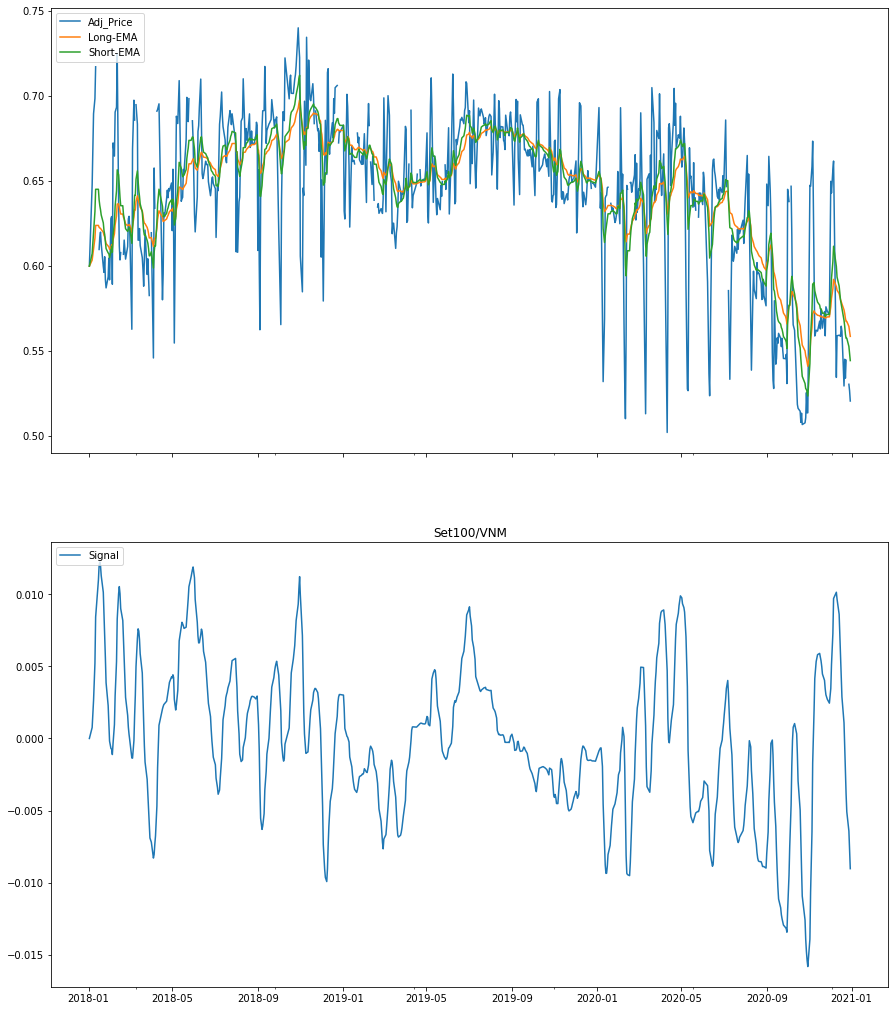

In [11]:
#Vizualization
fig1,ax = plt.subplots(2, sharex=True,figsize= (15,20))
#Plot Upper
ax[0].plot(df[f'{df.columns[0]}/{df.columns[1]}'],label= "Adj_Price")
df.EMA26.plot(ax=ax[0],kind='line' ,label='Long-EMA')
df.EMA12.plot(ax=ax[0],kind='line' ,label='Short-EMA')
ax[0].legend(loc = 'upper left')

#Plot Lower
ax[1].plot(df['Signal'],label = "Signal")
ax[1].legend(loc = 'upper left')
plt.title('Set100/VNM')
plt.show()

## Summary Stat Key

In [12]:
Max_Port, date_max_Port =result.Port_Val.max(), result.Port_Val.idxmax().strftime("%d/%m/%y") #Max Port Value
Min_Port, date_min_Port =result.Port_Val.min(), result.Port_Val.idxmin().strftime("%d/%m/%y") #Min Port value
Max_Total_Value, date_max_Value = result.Total_Port.max(), result.Total_Port.idxmax().strftime("%d/%m/%y") #Max Total Port
Min_Total_Value, date_min_Value = result.Total_Port.min(), result.Total_Port.idxmin().strftime("%d/%m/%y")
Max_Price, date_max_Price = result[f'{result.columns[2]}'].max(), result[f'{result.columns[2]}'].idxmax().strftime("%d/%m/%y")
Min_Price, date_min_Price = result[f'{result.columns[2]}'].min(), result[f'{result.columns[2]}'].idxmin().strftime("%d/%m/%y")
print("           MAX (Date)                   MIN (Date)    ")
print("--------------------------------------------------------------")
print(f"Port   |   {Max_Port:.4f}; {date_max_Port:}     {Min_Port:.4f}; {date_min_Port}")
print(f"Value  |   {Max_Total_Value:.4f}; {date_max_Value}     {Min_Total_Value:.4f}; {date_min_Value}")
print(f"Price  |   {Max_Price:.4f};       {date_max_Price}     {Min_Price:.4f};    {date_min_Price}")

           MAX (Date)                   MIN (Date)    
--------------------------------------------------------------
Port   |   2540696.4000; 29/12/20     3323.4000; 02/01/18
Value  |   2545255.9973; 29/12/20     3333.3333; 02/01/18
Price  |   0.7400;       29/10/18     0.5021;    11/04/20


In [13]:
principal = 100000
daily = principal/30
Init_inst = len(df.index)*daily
Profit = result.Total_Port.iloc[len(df.index)-1] - Init_inst
Percent_Profit = 100*Profit/Init_inst
print(f"   Last Day       {df.columns[0]}    {df.columns[1]}")
print("----------------------------------")
print(f"Number of Stock| {result.Accum_1.max()}     {result.Accum_2.max()}")
print(f"Port Value     | {result.Port_Val.iloc[len(df.index)-1]:.4f}" )
print(f"Cash Balance   | {result.Cash_Balance.iloc[len(df.index)-1]:.4f}")
print(f"Total_Port     | {result.Total_Port.iloc[len(df.index)-1]:.4f}")
print(f"Initail Invest | {Init_inst:.4f}")
print(f"Total Profit   | {Profit:.4f}")
print(f"% Total Profit | {Percent_Profit:.4f}"+"%")
print("Remark: 2 years DCA based on MACD selection SET100/VNM")
print("Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 730 Days, n= 24.33 round")

   Last Day       BSET100    VNM
----------------------------------
Number of Stock| 125039.0     79614.0
Port Value     | 2532350.2900
Cash Balance   | 4567.7807
Total_Port     | 2536918.0707
Initail Invest | 2433333.3333
Total Profit   | 103584.7373
% Total Profit | 4.2569%
Remark: 2 years DCA based on MACD selection SET100/VNM
Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 730 Days, n= 24.33 round


## Maximum Drawdown

In [14]:
#Maximum drawdown two-periods annually
def drawdown(series: pd.Series):
    """Takes a time series of asset price.
       returns a DataFrame with columns for 
       the previous peaks, and 
       the percentage drawdown
    """
    previous_peaks = series.cummax()
    drawdowns = (series - previous_peaks)/previous_peaks
    return pd.DataFrame({"series": series, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

In [15]:
drawdown(df[df.columns[2]]).min()

series           0.502085
Previous Peak    0.599877
Drawdown        -0.321495
dtype: float64

In [63]:
def Rolling_Drawdown(dataframe, window):
    
    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dataframe[f'{dataframe.columns[2]}'].rolling(window, min_periods=1).max()
    Dialy_Drawdown = dataframe[f'{dataframe.columns[2]}']/Roll_Max - 1.0
    
    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Dialy_Drawdown =Dialy_Drawdown.rolling(window, min_periods = 1).min()
    
    # Plot the results
    Daily_Drawdown.plot(figsize=(15,10))
    Max_Daily_Drawdown.plot()
    plt.title("Yearly Maximum Drawdown")
    plt.show()
    print(f"Maximum Drawdown: {Max_Daily_Drawdown.min()*100}%")

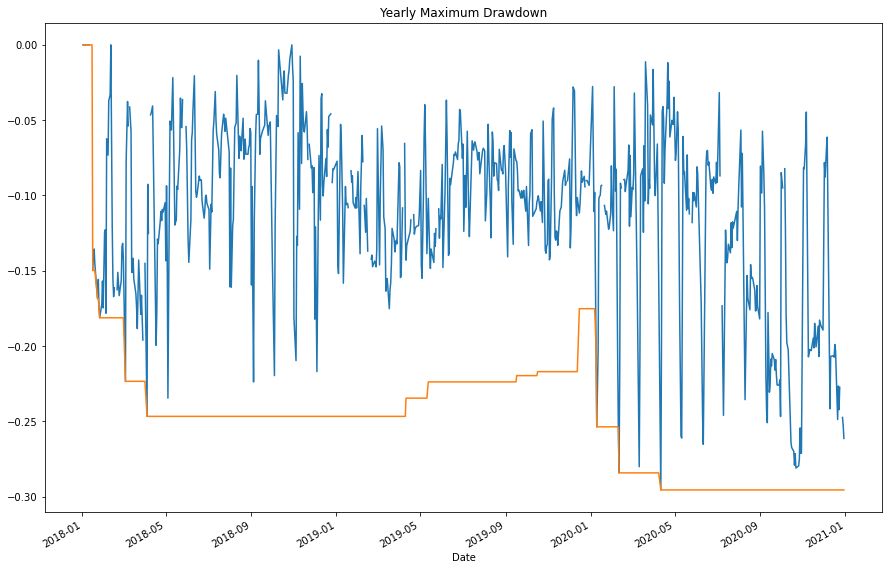

Maximum Drawdown: -29.563640609210097%


In [64]:
Rolling_Drawdown(df,252)

## Sharpe Ratio

In [ ]:
#Sharpe Ratio #Dialy return(array)
def sharpe(returns, rf, days=252): #trading day = 252
    volatility = returns.std() * np.sqrt(days)
    sharpe_ratio = (returns.mean() - rf) / volatility
    return sharpe_ratio, volatility

In [ ]:
print(f"Sharpe Ratio   | {sharpe(Profit, 0):.4f}")

# Annual Rolling

In [ ]:
round(len(df)/252) #window is set to 252

In [17]:
data = gen_df(name)

In [45]:
#Slicing to 2 year and 0.89 (11 month)
df1 = data[:window]
df2 = data[window:window*2]
df3 = data[window*2:window*3]

In [46]:
result1, acc_cash1 = dollar_cost_average(df1, genr_stat(df1), 100000)
result2, acc_cash2 = dollar_cost_average(df2, genr_stat(df2), 100000)
result3, acc_cash3 = dollar_cost_average(df3, genr_stat(df3), 100000)

<ipython-input-20-5fd3cfcde5c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f'{df.columns[0]}/{dataframe.columns[1]}'] = dataframe[f'{dataframe.columns[0]}'].values.ravel()/dataframe[f'{df.columns[1]}'].values.ravel() #Fix slicing
<ipython-input-20-5fd3cfcde5c8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['EMA26'] = dataframe[f'{df.columns[0]}/{df.columns[1]}'].ewm(span = 26, adjust=False).mean() #spanday = 26
<ipython-input-20-5fd3cfcde5c8>:9: SettingWithCopyWarning: 
A value 

3333.3333333333335
3333.3333333333335
3333.3333333333335


<ipython-input-37-915df98e1f00>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.iloc[num, dataframe.columns.get_loc('Num_2')] = np.floor(daily/df[f'{dataframe.columns[1]}'].iloc[num])
<ipython-input-37-915df98e1f00>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.iloc[num, dataframe.columns.get_loc('Accum_2')] = sum(num_2) #Acc_VN
<ipython-input-37-915df98e1f00>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [53]:
Max_Port, date_max_Port =result1.Port_Val.max(), result1.Port_Val.idxmax().strftime("%d/%m/%y") #Max Port Value
Min_Port, date_min_Port =result1.Port_Val.min(), result1.Port_Val.idxmin().strftime("%d/%m/%y") #Min Port value
Max_Total_Value, date_max_Value = result1.Total_Port.max(), result1.Total_Port.idxmax().strftime("%d/%m/%y") #Max Total Port
Min_Total_Value, date_min_Value = result1.Total_Port.min(), result1.Total_Port.idxmin().strftime("%d/%m/%y")
Max_Price, date_max_Price = result1[f'{result1.columns[2]}'].max(), result1[f'{result1.columns[2]}'].idxmax().strftime("%d/%m/%y")
Min_Price, date_min_Price = result1[f'{result1.columns[2]}'].min(), result1[f'{result1.columns[2]}'].idxmin().strftime("%d/%m/%y")
print("           MAX (Date)                   MIN (Date)    ")
print("--------------------------------------------------------------")
print(f"Port   |   {Max_Port:.4f}; {date_max_Port:}     {Min_Port:.4f}; {date_min_Port}")
print(f"Value  |   {Max_Total_Value:.4f}; {date_max_Value}     {Min_Total_Value:.4f}; {date_min_Value}")
print(f"Price  |   {Max_Price:.4f};       {date_max_Price}     {Min_Price:.4f};    {date_min_Price}")
principal = 100000
daily = principal/30
Init_inst = len(df1.index)*daily
Profit = result.Total_Port.iloc[len(df1.index)-1] - Init_inst
Percent_Profit = 100*Profit/Init_inst
print(f"   Last Day       {df1.columns[0]}    {df1.columns[1]}")
print("----------------------------------")
print(f"Number of Stock| {result1.Accum_1.max()}     {result1.Accum_2.max()}")
print(f"Port Value     | {result1.Port_Val.iloc[len(df1.index)-1]:.4f}" )
print(f"Cash Balance   | {result1.Cash_Balance.iloc[len(df1.index)-1]:.4f}")
print(f"Total_Port     | {result1.Total_Port.iloc[len(df1.index)-1]:.4f}")
print(f"Initail Invest | {Init_inst:.4f}")
print(f"Total Profit   | {Profit:.4f}")
print(f"% Total Profit | {Percent_Profit:.4f}"+"%")
print("--------------------------------------")
print("First_Year Rolling")
print("Remark: 3 years DCA based on MACD selection SET100/VNM")
print("Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 252 Days, n= 1 round")

           MAX (Date)                   MIN (Date)    
--------------------------------------------------------------
Port   |   842063.1373; 07/01/19     3323.4000; 02/01/18
Value  |   843725.7534; 07/01/19     3333.3333; 02/01/18
Price  |   0.7400;       29/10/18     0.5459;    04/04/18
   Last Day       BSET100    VNM
----------------------------------
Number of Stock| 37168.0     26981.0
Port Value     | 823391.1873
Cash Balance   | 1684.6261
Total_Port     | 825075.8133
Initail Invest | 840000.0000
Total Profit   | -14924.1867
% Total Profit | -1.7767%
--------------------------------------
First_Year Rolling
Remark: 3 years DCA based on MACD selection SET100/VNM
Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 252 Days, n= 1 round


In [57]:
Max_Port, date_max_Port =result2.Port_Val.max(), result2.Port_Val.idxmax().strftime("%d/%m/%y") #Max Port Value
Min_Port, date_min_Port =result2.Port_Val.min(), result2.Port_Val.idxmin().strftime("%d/%m/%y") #Min Port value
Max_Total_Value, date_max_Value = result2.Total_Port.max(), result2.Total_Port.idxmax().strftime("%d/%m/%y") #Max Total Port
Min_Total_Value, date_min_Value = result2.Total_Port.min(), result2.Total_Port.idxmin().strftime("%d/%m/%y")
Max_Price, date_max_Price = result2[f'{result2.columns[2]}'].max(), result2[f'{result2.columns[2]}'].idxmax().strftime("%d/%m/%y")
Min_Price, date_min_Price = result2[f'{result2.columns[2]}'].min(), result2[f'{result2.columns[2]}'].idxmin().strftime("%d/%m/%y")
print("           MAX (Date)                   MIN (Date)    ")
print("--------------------------------------------------------------")
print(f"Port   |   {Max_Port:.4f}; {date_max_Port:}     {Min_Port:.4f}; {date_min_Port}")
print(f"Value  |   {Max_Total_Value:.4f}; {date_max_Value}     {Min_Total_Value:.4f}; {date_min_Value}")
print(f"Price  |   {Max_Price:.4f};       {date_max_Price}     {Min_Price:.4f};    {date_min_Price}")
principal = 100000
daily = principal/30
Init_inst = len(df2.index)*daily
Profit = result2.Total_Port.iloc[len(df2.index)-1] - Init_inst
Percent_Profit = 100*Profit/Init_inst
print(f"   Last Day       {df2.columns[0]}    {df2.columns[1]}")
print("----------------------------------")
print(f"Number of Stock| {result2.Accum_1.max()}     {result2.Accum_2.max()}")
print(f"Port Value     | {result2.Port_Val.iloc[len(df2.index)-1]:.4f}" )
print(f"Cash Balance   | {result2.Cash_Balance.iloc[len(df2.index)-1]:.4f}")
print(f"Total_Port     | {result2.Total_Port.iloc[len(df2.index)-1]:.4f}")
print(f"Initail Invest | {Init_inst:.4f}")
print(f"Total Profit   | {Profit:.4f}")
print(f"% Total Profit | {Percent_Profit:.4f}"+"%")
print("First_Year Rolling")
print("Remark: 3 years DCA based on MACD selection SET100/VNM")
print("Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 252 Days, n= 2 round")

           MAX (Date)                   MIN (Date)    
--------------------------------------------------------------
Port   |   845602.4001; 17/01/20     3329.7000; 14/01/19
Value  |   847236.0601; 17/01/20     3333.3333; 14/01/19
Price  |   0.7128;       08/06/19     0.5320;    10/01/20
   Last Day       BSET100    VNM
----------------------------------
Number of Stock| 44332.0     23885.0
Port Value     | 841393.9506
Cash Balance   | 1660.9861
Total_Port     | 843054.9367
Initail Invest | 840000.0000
Total Profit   | 3054.9367
% Total Profit | 0.3637%
First_Year Rolling
Remark: 3 years DCA based on MACD selection SET100/VNM
Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 252 Days, n= 2 round


In [62]:
Max_Port, date_max_Port =result3.Port_Val.max(), result3.Port_Val.idxmax().strftime("%d/%m/%y") #Max Port Value
Min_Port, date_min_Port =result3.Port_Val.min(), result3.Port_Val.idxmin().strftime("%d/%m/%y") #Min Port value
Max_Total_Value, date_max_Value = result3.Total_Port.max(), result3.Total_Port.idxmax().strftime("%d/%m/%y") #Max Total Port
Min_Total_Value, date_min_Value = result3.Total_Port.min(), result3.Total_Port.idxmin().strftime("%d/%m/%y")
Max_Price, date_max_Price = result3[f'{result3.columns[2]}'].max(), result3[f'{result3.columns[2]}'].idxmax().strftime("%d/%m/%y")
Min_Price, date_min_Price = result3[f'{result3.columns[2]}'].min(), result3[f'{result3.columns[2]}'].idxmin().strftime("%d/%m/%y")
print("           MAX (Date)                   MIN (Date)    ")
print("--------------------------------------------------------------")
print(f"Port   |   {Max_Port:.4f}; {date_max_Port:}     {Min_Port:.4f}; {date_min_Port}")
print(f"Value  |   {Max_Total_Value:.4f}; {date_max_Value}     {Min_Total_Value:.4f}; {date_min_Value}")
print(f"Price  |   {Max_Price:.4f};       {date_max_Price}     {Min_Price:.4f};    {date_min_Price}")
principal = 100000
daily = principal/30
Init_inst = len(df3.index)*daily
Profit = result3.Total_Port.iloc[len(df3.index)-1] - Init_inst
Percent_Profit = 100*Profit/Init_inst
print(f"   Last Day       {df3.columns[0]}    {df3.columns[1]}")
print("----------------------------------")
print(f"Number of Stock| {result3.Accum_1.max()}     {result3.Accum_2.max()}")
print(f"Port Value     | {result3.Port_Val.iloc[len(df3.index)-1]:.4f}" )
print(f"Cash Balance   | {result3.Cash_Balance.iloc[len(df3.index)-1]:.4f}")
print(f"Total_Port     | {result3.Total_Port.iloc[len(df3.index)-1]:.4f}")
print(f"Initail Invest | {Init_inst:.4f}")
print(f"Total Profit   | {Profit:.4f}")
print(f"% Total Profit | {Percent_Profit:.4f}"+"%")
print("First_Year Rolling")
print("Remark: 3 years DCA based on MACD selection SET100/VNM")
print("Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 226 Days, n= 3 round")

           MAX (Date)                   MIN (Date)    
--------------------------------------------------------------
Port   |   921824.9161; 30/12/20     3326.1900; 24/01/20
Value  |   923040.5963; 30/12/20     3333.3333; 24/01/20
Price  |   0.7048;       20/03/20     0.5021;    11/04/20
   Last Day       BSET100    VNM
----------------------------------
Number of Stock| 46191.0     27045.0
Port Value     | 921824.9161
Cash Balance   | 1215.6802
Total_Port     | 923040.5963
Initail Invest | 753333.3333
Total Profit   | 169707.2630
% Total Profit | 22.5275%
First_Year Rolling
Remark: 3 years DCA based on MACD selection SET100/VNM
Total Principal: 100000 per 30 days , dialy = 3333.333, Total Day = 226 Days, n= 3 round


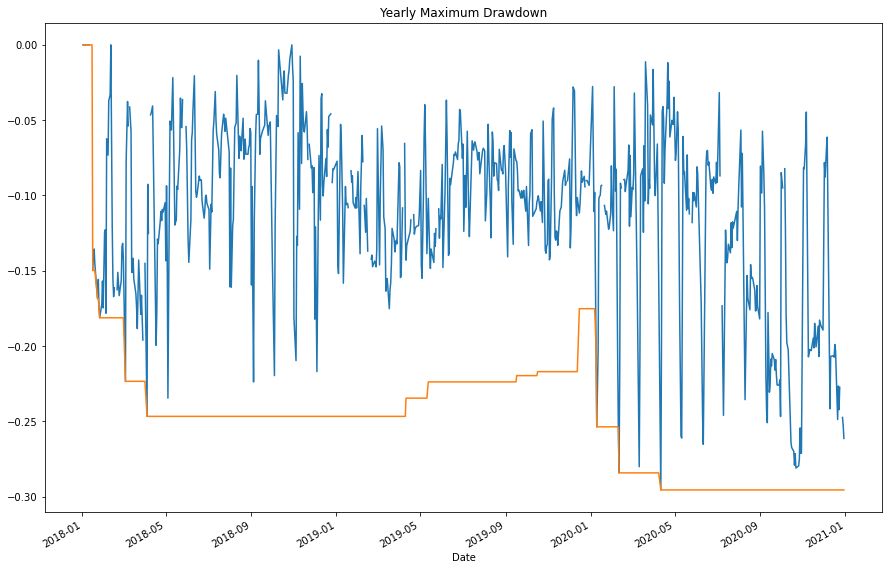

Maximum Drawdown: -29.563640609210097%


In [67]:
Rolling_Drawdown(df1,252)

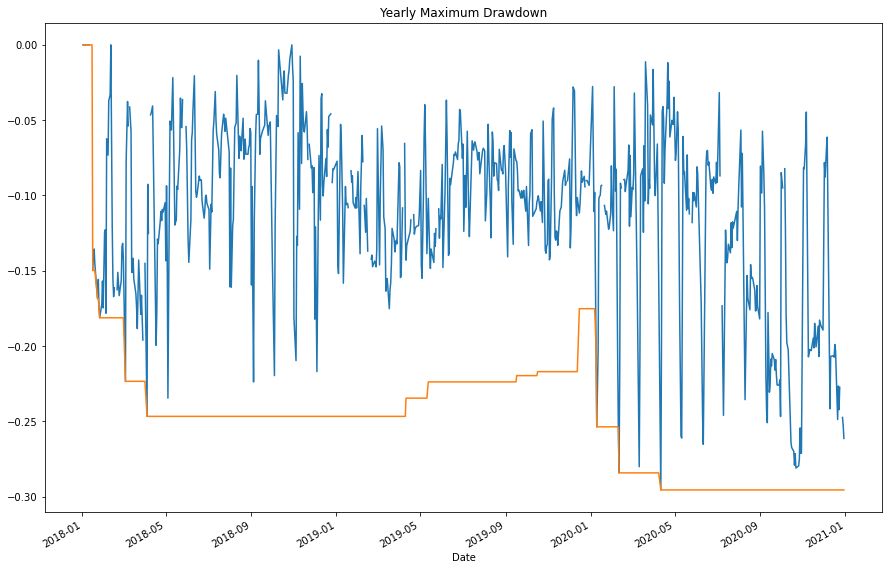

Maximum Drawdown: -29.563640609210097%


In [66]:
Rolling_Drawdown(df2,252)

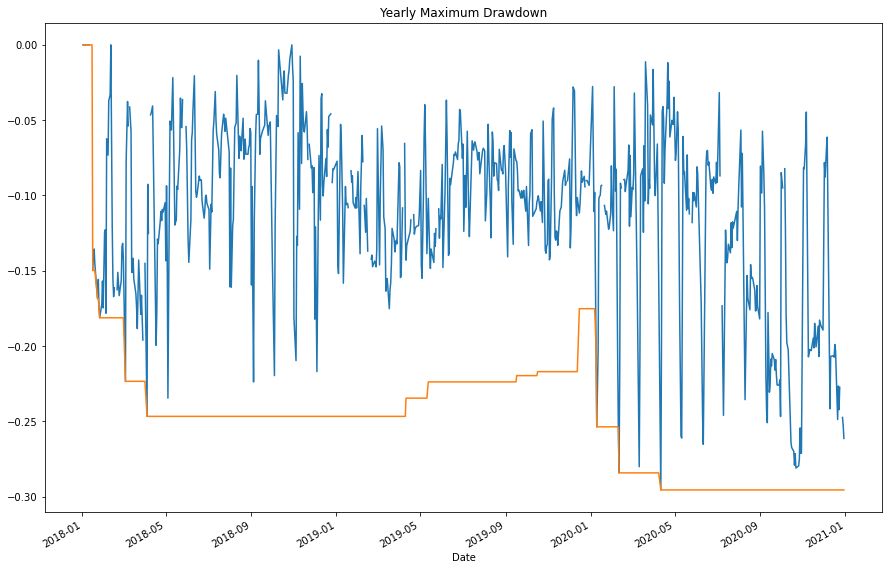

Maximum Drawdown: -29.563640609210097%


In [65]:
Rolling_Drawdown(df3,252)